In [15]:
# !git clone 'https://github.com/Lorenz92/SKADC1.git'
# % cd SKADC1
# !echo $PWD

In [16]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import sys
from astropy.io import fits
import os
import statistics

import src.dataset as dataset
import src.datasetv2 as v2
import src.config as config
from src.utils import *
import src.preprocessing as prep
import src.models as models
import src.losses as loss

from keras import backend as K

path = config.TRAIN_PATCHES_FOLDER
%load_ext autoreload
%autoreload 2

np.random.seed(config.RANDOM_SEED)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
for download_info in config.required_files:
    if not os.path.exists(os.path.join(config.TRAIN_DATA_FOLDER, download_info['file_name'])):
        download_data(download_info['file_name'], download_info['url'], config.DOWNLOAD_FOLDER)

In [18]:
# Dataset parsing and loading
# use "subset" to load a small portion of data for development/debugging purposes
# ska_dataset_cleanedByClaran = dataset.SKADataset(train_set_path=config.TRAIN_SET_PATH_CLEANED, subset=config.DATA_SUBSET)

# ska_dataset = dataset.SKADataset(train_set_path=config.TRAIN_SET_PATH, subset=config.DATA_SUBSET)
ska_dataset = dataset.SKADataset(train_set_path=config.TRAIN_SET_PATH_CLEANED, subset=config.DATA_SUBSET)

# print(ska_dataset_cleanedByClaran.raw_train_df.shape)
print(ska_dataset.raw_train_df.shape)
ska_dataset.raw_train_df.head()

(19222, 15)


,ID,RA (core),DEC (core),RA (centroid),DEC (centroid),FLUX,Core frac,BMAJ,BMIN,PA,SIZE,CLASS,SELECTION,x,y
0,24121695,-0.642227,-29.775242,-0.642316,-29.775211,0.000035,0.000000,5.600,5.551,328.554,1,1,1,19704.519,17712.942
1,20167150,-0.390473,-29.867493,-0.390667,-29.868851,0.029555,0.016924,107.110,43.263,191.258,1,1,1,18401.338,17160.919
2,20045120,-0.021411,-29.643486,-0.021359,-29.643561,0.000653,0.012185,5.037,3.525,276.587,1,1,1,16493.600,18506.577
3,33938384,-0.316375,-29.697647,-0.316375,-29.697647,0.000017,0.000000,0.847,0.266,346.641,2,1,1,18020.319,18182.095
4,7527248,-0.336528,-29.627335,-0.336527,-29.627338,0.000054,0.044763,3.343,1.515,279.006,1,1,1,18125.824,18600.680


In [19]:
data_560Mhz_1000h_fits = fits.open('./data/training/560Mhz_1000h.fits')
# pb_560Mhz_1000h_fits = fits.open('./data/training/PrimaryBeam_B1.fits')
# data_560Mhz_1000h_fits.info()
data_560Mhz_1000h_fits.filename()

# print(data_560Mhz_1000h_fits[0].data)
# print(data_560Mhz_1000h_fits[0].data.shape)

data_560Mhz_1000h = data_560Mhz_1000h_fits[0].data[0,0]


### Preprocessing

In [20]:
ska_dataset.convert_boxes_to_px_coord(ska_dataset.raw_train_df, data_560Mhz_1000h_fits)
#coords = ska_dataset._convert_boxes_to_px_coord(ska_dataset.raw_train_df, data_560Mhz_1000h_fits[0].header )

100%|██████████| 19222/19222 [00:02<00:00, 6983.47it/s]
(19222, 15)
15
9
(19207, 15)
15
0
Enlarging bboxes...
DONE - Enlarging bboxes...


In [21]:
df_train = ska_dataset.cleaned_train_df
df_train.head()

,ID,RA (core),DEC (core),RA (centroid),DEC (centroid),FLUX,Core frac,BMAJ,BMIN,PA,...,y,x1,y1,x2,y2,major_semia_px,minor_semia_px,pa_in_rad,width,height
0,24121695.0,-0.642227,-29.775242,-0.642316,-29.775211,0.000035,0.000000,5.600,5.551,328.554,...,17712.942,19699.889820,17708.334874,19709.135520,17717.543623,4.633850,4.593304,5.734349,9.245699,9.208748
1,20167150.0,-0.390473,-29.867493,-0.390667,-29.868851,0.029555,0.016924,107.110,43.263,191.258,...,17160.919,18314.128617,17121.775102,18488.540079,17200.059688,88.630651,35.798972,3.338082,174.411463,78.284586
2,20045120.0,-0.021411,-29.643486,-0.021359,-29.643561,0.000653,0.012185,5.037,3.525,276.587,...,18506.577,16490.663037,18502.418816,16496.536575,18510.726749,4.167982,2.916843,4.827354,5.873538,8.307933
3,33938384.0,-0.316375,-29.697647,-0.316375,-29.697647,0.000017,0.000000,0.847,0.266,346.641,...,18182.095,18018.267603,18181.289542,18022.370397,18182.900458,0.700870,0.220108,6.050027,4.102794,1.610916
4,7527248.0,-0.336528,-29.627335,-0.336527,-29.627338,0.000054,0.044763,3.343,1.515,279.006,...,18600.680,18124.509296,18597.936034,18127.132703,18603.414392,2.766243,1.253622,4.869573,2.623407,5.478358


In [22]:
df_train[['width', 'height']].describe()

,width,height
count,19207.000000,19207.000000
mean,4.075587,4.093373
std,3.459175,3.359250
min,0.009930,0.009930
25%,2.316125,2.356320
50%,3.475087,3.470834
75%,4.761761,4.780523
max,174.411463,92.846556


In [23]:
x1_min = int(np.floor(min(df_train['x1'])))
y1_min = int(np.floor(min(df_train['y1'])))

x2_max = int(np.floor(max(df_train['x2'])))
y2_max = int(np.floor(max(df_train['y2'])))

data_560Mhz_1000h_train = data_560Mhz_1000h[y1_min:y2_max, x1_min:x2_max]
data_560Mhz_1000h_train.shape


(3195, 3500)

(array([1.705e+03, 4.870e+02, 2.400e+02, 1.060e+02, 2.700e+01, 2.100e+01,
        1.500e+01, 8.000e+00, 6.000e+00, 2.000e+00, 5.000e+00, 5.000e+00,
        3.000e+00, 3.000e+00, 3.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 2.000e+00, 3.000e+00,
        2.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]),
 array([1.0000e-04, 2.4750e-04, 3.9500e-04, 5.4250e-04, 6.9000e-04,
        8.3750e-04, 9.8500e-04, 1.1325e-03, 1.2800e-03, 1.4275e-03,
        1.5750e-03, 1.7225e-03, 1.8700e-03, 2.0175e-03, 2.1650e-03,
        2.3125e-03, 2.4600e-03, 2.6075e-03, 2.7550e-03, 2.9025e-03,
        3.0500e-03, 3.1975e-03, 3.3450e-03, 3.4925e-03, 3.6400e-03,
        3.7875e-03, 3.9350e-03, 4.0825e-03, 4.2300e-03, 4.3775e-03,
        4.5250e-03, 4.6725e-03, 4.8200e-03, 4.9675e-03, 5.1150e-03,
        5.2625e-03, 5.4100

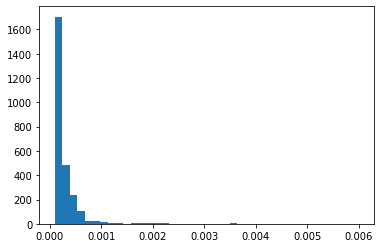

In [24]:
# histogram of noise (- noise, + noise)
# we know that negative values are due to noise, and we assume a gaussian noise distribution

data_flat = data_560Mhz_1000h_train.flatten()
min_val = min(data_flat)
plt.hist(data_flat, bins = 40, range = (0.0001, 0.006))#abs(min_val)))

In [25]:
# fits_max_data_560Mhz_1000h = np.max(data_560Mhz_1000h)
# print(fits_max_data_560Mhz_1000h)

# data_560Mhz_1000h_train_clipped = np.clip(data_560Mhz_1000h_train, a_min=0, a_max=fits_max_data_560Mhz_1000h)

# # NB the computation of the mean val must be after the noise removal
# data_flat = data_560Mhz_1000h_train_clipped.flatten()
# mean_GLval = statistics.mean(data_flat)
# max_GLval = max(data_flat)
# min_GLval = min(data_flat)
# print(mean_GLval)
# print(max_GLval)
# print(min_GLval)

In [26]:
data_560Mhz_1000h_train_clipped = np.clip(data_560Mhz_1000h_train, a_min=0, a_max=np.max(data_560Mhz_1000h))


In [27]:
patch_list=[]
patch_list = ska_dataset.split_in_patch(data_560Mhz_1000h_train_clipped, df_train, data_560Mhz_1000h_fits.filename(), x1_min, y1_min, config.patch_dim, show_plot=False) # Remember to remove internal return

  1%|▏         | 1/70 [00:00<00:33,  2.07it/s]image saved

  3%|▎         | 2/70 [00:00<00:32,  2.08it/s]image saved

  4%|▍         | 3/70 [00:01<00:32,  2.06it/s]image saved

  6%|▌         | 4/70 [00:01<00:31,  2.07it/s]image saved

  7%|▋         | 5/70 [00:02<00:31,  2.08it/s]image saved

  9%|▊         | 6/70 [00:02<00:30,  2.11it/s]image saved

 10%|█         | 7/70 [00:03<00:29,  2.10it/s]image saved

 11%|█▏        | 8/70 [00:03<00:29,  2.13it/s]image saved

 13%|█▎        | 9/70 [00:04<00:28,  2.15it/s]image saved

 14%|█▍        | 10/70 [00:04<00:28,  2.14it/s]image saved

 16%|█▌        | 11/70 [00:05<00:27,  2.15it/s]image saved

 17%|█▋        | 12/70 [00:05<00:27,  2.10it/s]image saved

 19%|█▊        | 13/70 [00:06<00:26,  2.14it/s]image saved

 20%|██        | 14/70 [00:06<00:25,  2.18it/s]image saved

 21%|██▏       | 15/70 [00:07<00:24,  2.22it/s]image saved

 23%|██▎       | 16/70 [00:07<00:24,  2.25it/s]image saved

 24%|██▍       | 17/70 [00:07<00:23,  2.28it/s]im

In [28]:
ska_dataset.proc_train_df[ska_dataset.proc_train_df['ID']==14777429]

,ID,RA (core),DEC (core),RA (centroid),DEC (centroid),FLUX,Core frac,BMAJ,BMIN,PA,...,y1s,x2s,y2s,patch_name,patch_xo,patch_yo,patch_dim,bbox_w,bbox_h,class_label


In [29]:
# TODO: trasfromare in attributo della classe dataset
class_list = ska_dataset.proc_train_df['class_label'].unique()
print(class_list)

num_classes = len(ska_dataset.proc_train_df['class_label'].unique())
print(num_classes)

['1_1' '2_1' '3_1']
3


## Preprocessing - TODO:
- unire bbox sovrapposte?

In [30]:
#TODO: spostare in dataset dopo aver sistemato la classe dataset
from sklearn.model_selection import train_test_split

# train_patch_list, val_patch_list = train_test_split(patch_list, test_size=.2, random_state=42)
train_patch_list = patch_list

In [31]:
# print(len(train_patch_list))
# # print(len(val_patch_list))

## datagen + calc_rpn -> rpn_net -> rpn_to_roi -> calc_iou -> cls_net

# Training

### Get FRCNN model

In [32]:
input_shape_1=(config.resizeFinalDim, config.resizeFinalDim,1)
input_shape_2=(None, 4)

backbone='vgg16'

rpn_model, detector_model, total_model = models.get_train_model(input_shape_1=input_shape_1, input_shape_2=input_shape_2, anchor_num=config.anchor_num, pooling_regions=7, num_rois=4, num_classes=len(class_list)+1, backbone=backbone, use_expander=False)

rpn_model.summary()
detector_model.summary()
total_model.summary()

Model: "RegionProposal"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 600, 600, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 600, 600, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 600, 600, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 300, 300, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 300, 300, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 300, 300, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 150, 150, 128)  

In [33]:
input_shape_1=(config.resizeFinalDim, config.resizeFinalDim,1)
input_shape_2=(None, 4)

backbone='vgg16'

rpn_model_eval, detector_model_eval, total_model_eval = models.get_eval_model(input_shape_1=input_shape_1, input_shape_2=input_shape_2, input_shape_fmap=None, anchor_num=config.anchor_num, pooling_regions=7, num_rois=4, num_classes=len(class_list)+1, backbone=backbone, use_expander=False)

rpn_model_eval.summary()
detector_model_eval.summary()
total_model_eval.summary()

Model: "RegionProposal"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 600, 600, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 600, 600, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 600, 600, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 300, 300, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 300, 300, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 300, 300, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 150, 150, 128)  

### Load weights

In [34]:
models.load_weigths(rpn_model, detector_model, backbone, resume_train=True)
models.compile_models(rpn_model, detector_model, total_model, rpn_losses=[loss.rpn_loss_cls, loss.rpn_loss_regr], detector_losses=[loss.detector_loss_cls, loss.detector_loss_regr], class_list=class_list)

In [35]:
# total_model.weights[24:25]

In [36]:
# # Specifically checking backbone weights

# total_model_eval.weights[24:25]#[0][0][0][0]

In [37]:
# total_model.weights[38:39]#[0][0][0][0]

In [38]:
# # Check that all of the pretrained weights have been loaded.
# import numpy as np
# for i, j in zip(total_model.weights, total_model_eval.weights): 
#     # print(i,j)
#     assert np.allclose(i,j), 'Weights don\'t match!'

### Train

In [39]:
from src.train import *
val_patch_list = None
train_frcnn(rpn_model, detector_model, total_model, train_patch_list, val_patch_list, class_list, config.TRAIN_PATCHES_FOLDER, backbone='vgg16', resume_train=True, use_expander=False)

9: RuntimeWarning: invalid value encountered in add
  A[3, :, :, anchor_index] += A[1, :, :, anchor_index]
Best IoU found in this run: 0.4775778741655073
Starting detector model training on batch
  0%|          | 0/5 [00:00<?, ?it/s]150_16524_16729_100

100%|██████████| 5/5 [00:14<00:00,  2.81s/it]

100%|██████████| 9/9 [00:00<00:00, 38479.85it/s]
Starting rpn model training on batch
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/utils.py:267: RuntimeWarning: overflow encountered in exp
  w1 = np.exp(tw.astype(np.float64)) * w
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/utils.py:138: RuntimeWarning: invalid value encountered in add
  A[2, :, :, anchor_index] += A[0, :, :, anchor_index]
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/utils.py:268: RuntimeWarning: overflow encountered in exp
  h1 = np.exp(th.astype(np.float64)) * h
/Users/lorenzocellini/AI

In [68]:
class_mapping = {key:value for value, key in enumerate(class_list)}
class_mappingv2 = {value:key for value, key in enumerate(class_list)}

In [67]:
class_list

array(['1_1', '2_1', '3_1'], dtype=object)

In [66]:
class_mapping

{'1_1': 0, '2_1': 1, '3_1': 2}

In [70]:
class_mappingv2[1]

'2_1'

# Validation

In [46]:
# Models used for mAP eval
models.load_weigths(rpn_model_eval, detector_model_eval, backbone, resume_train=True)
models.compile_models(rpn_model_eval, detector_model_eval, total_model_eval, rpn_losses=[loss.rpn_loss_cls, loss.rpn_loss_regr], detector_losses=[loss.detector_loss_cls, loss.detector_loss_regr], class_list=class_list)

In [47]:
import time
from tqdm import tqdm

def get_real_coordinates(x1, y1, x2, y2):
    ratio = config.resizeFinalDim / config.patch_dim
    real_x1 = int(round(x1 // ratio))
    real_y1 = int(round(y1 // ratio))
    real_x2 = int(round(x2 // ratio))
    real_y2 = int(round(y2 // ratio))

    return (real_x1, real_y1, real_x2 ,real_y2)

def generate_output(img_name, bboxes, probs, plot=False):
    all_dets = []
    [img_name] = img_name
    boxes_coords ={'x1s':[], 'y1s':[], 'x2s':[], 'y2s':[], 'class':[], 'prob':[]}
    
    for key in bboxes:
        bbox = np.array(bboxes[key])

        new_boxes, new_probs = non_max_suppression_fast(bbox, np.array(probs[key]), overlap_thresh=0.5)
       
        for jk in range(new_boxes.shape[0]):
            (x1, y1, x2, y2) = new_boxes[jk,:]
            print((x1, y1, x2, y2))
            (real_x1, real_y1, real_x2, real_y2) = get_real_coordinates(x1, y1, x2, y2)

            boxes_coords['x1s'].append(real_x1)
            boxes_coords['y1s'].append(real_y1)
            boxes_coords['x2s'].append(real_x2)
            boxes_coords['y2s'].append(real_y2)
            boxes_coords['class'].append(key)
            boxes_coords['prob'].append(new_probs[jk])

    a = pd.DataFrame.from_dict(boxes_coords)
    display(a.head())
    a.to_pickle(f'{config.VAL_PATCHES_FOLDER}/{img_name}/{img_name}.pkl')

    return boxes_coords

def predict(image, class_list):
    start = time.time()

    print('Predict')

    # get the feature maps and output from the RPN
    [Y1, Y2, F] = rpn_model_eval.predict_on_batch(image)
    # [Y1, Y2] = rpn_model.predict_on_batch(image)

    print('rpn_to_roi')

    R = rpn_to_roi(Y1, Y2, overlap_thresh=0.5)

    # convert from (x1,y1,x2,y2) to (x,y,w,h)
    R[:, 2] -= R[:, 0]
    R[:, 3] -= R[:, 1]

    bboxes = {}
    probs = {}

    for jk in range(R.shape[0] // C.num_rois + 1):
        ROIs = np.expand_dims(R[C.num_rois * jk:C.num_rois * (jk + 1), :], axis=0)
        if ROIs.shape[1] == 0:
            break

        if jk == R.shape[0] // C.num_rois:
            # pad R
            curr_shape = ROIs.shape
            target_shape = (curr_shape[0], C.num_rois, curr_shape[2])
            ROIs_padded = np.zeros(target_shape).astype(ROIs.dtype)
            ROIs_padded[:, :curr_shape[1], :] = ROIs
            ROIs_padded[0, curr_shape[1]:, :] = ROIs[0, 0, :]
            ROIs = ROIs_padded

        [P_cls, P_regr] = detector_model_eval.predict([F, ROIs])
        # [P_cls, P_regr] = detector_model.predict([image, ROIs])
        print(P_cls.shape)
        print(P_cls)
        for ii in range(P_cls.shape[1]):
            # if classification perc is too low OR it is. a 'bg' image THEN discard
            if np.max(P_cls[0,ii,:]) < 0. or np.argmax(P_cls[0,ii,:]) == (P_cls.shape[2] - 1):
                continue

            cls_num = np.argmax(P_cls[0, ii, :])
            cls_name = class_mapping[cls_num]

            if cls_name not in bboxes:
                bboxes[cls_name] = []
                probs[cls_name] = []
            (x,y,w,h) = ROIs[0,ii,:]
            
            try:
                (tx, ty, tw, th) = P_regr[0, ii, 4*cls_num:4*(cls_num+1)]
                tx /= config.classifier_regr_std[0]
                ty /= config.classifier_regr_std[1]
                tw /= config.classifier_regr_std[2]
                th /= config.classifier_regr_std[3]
                
                X, T = np.zeros((4, 1, 1)), np.zeros((4, 1, 1))
                
                X[0,0,0] = x
                X[1,0,0] = y
                X[2,0,0] = w
                X[3,0,0] = h
                
                T[0,0,0] = tx
                T[1,0,0] = ty
                T[2,0,0] = tw
                T[3,0,0] = th
                
                [[[x_np]], [[y_np]], [[w_np]], [[h_np]]] = apply_regr_np(X, T)
            except:
                pass
            bboxes[cls_name].append([config.rpn_stride*x, config.rpn_stride*y, config.rpn_stride*(x+w), config.rpn_stride*(y+h)])
            probs[cls_name].append(np.max(P_cls[0, ii, :]))
    
   
    print(f'Elapsed:{time.time()-start}')
    return bboxes, probs


['50_16424_16729_100']


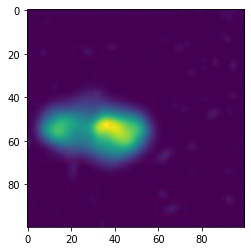

In [45]:
print(train_patch_list[1:2])
print_img(config.TRAIN_PATCHES_FOLDER, train_patch_list[1])


In [49]:
patch_id = train_patch_list[0:1]
print(patch_id)
gt = pd.read_pickle(f'{config.TRAIN_PATCHES_FOLDER}/{patch_id[0]}/{patch_id[0]}.pkl')
display(gt['class_label'])

class_mapping = {key:value for key, value in enumerate(class_list)}

eval_datagen = prep.get_anchor_gt(config.TRAIN_PATCHES_FOLDER, patch_id, mode='eval')
image, _, _, _, _ = next(eval_datagen)

if True:
    print(image.shape)
    image = np.repeat(image, 3, axis=3)
    print(image.shape)

bboxes, probs = predict(image, class_list)

# print('-'*10)
print(bboxes)
print(probs)

['0_16374_16729_100']


0     1_1
1     2_1
2     2_1
3     2_1
4     2_1
5     2_1
6     2_1
7     2_1
8     2_1
9     2_1
10    2_1
11    2_1
Name: class_label, dtype: object

  0%|          | 0/1 [00:00<?, ?it/s]0_16374_16729_100
(1, 600, 600, 1)
(1, 600, 600, 3)
Predict
rpn_to_roi
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/utils.py:267: RuntimeWarning: overflow encountered in exp
  w1 = np.exp(tw.astype(np.float64)) * w
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/utils.py:138: RuntimeWarning: invalid value encountered in add
  A[2, :, :, anchor_index] += A[0, :, :, anchor_index]
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/utils.py:268: RuntimeWarning: overflow encountered in exp
  h1 = np.exp(th.astype(np.float64)) * h
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/utils.py:139: RuntimeWarning: invalid value encountered in add
  A[3, :, :, anchor_index] += A[1, :, :, anchor_index]


InvalidArgumentError:  input image must be of non-zero size
	 [[node DetectorClassifier/roi_pooling/resize_3/ResizeBilinear (defined at /Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/layers.py:125) ]] [Op:__inference_predict_function_36973]

Function call stack:
predict_function


In [37]:
boxes_coords = generate_output(patch_id, bboxes, probs)

,x1s,y1s,x2s,y2s,class,prob


In [36]:
total_model.save_weights(f'{config.MODEL_WEIGHTS}/{backbone}/frcnn_{backbone}_20210629_21_4258.h5')


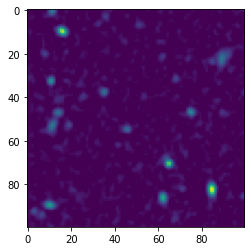

In [146]:
print_img(config.TRAIN_PATCHES_FOLDER, patch_id[0], config.VAL_PATCHES_FOLDER)

In [225]:
from sklearn.metrics import average_precision_score

def get_map(y_pred, gt_patch_id, data_folder):
	T = {}
	P = {}
	f = config.patch_dim / float(config.resizeFinalDim)

	gt = pd.read_pickle(f'{data_folder}/{gt_patch_id}/{gt_patch_id}.pkl')

	gt['bbox_matched'] = False
	pred_probs = np.array(y_pred['prob'])
	
	box_idx_sorted_by_prob = np.argsort(pred_probs)[::-1]

	for box_idx in box_idx_sorted_by_prob:
		pred_box = y_pred.iloc[box_idx,:]
		pred_class = pred_box['class']
		pred_x1 = pred_box['x1s']
		pred_x2 = pred_box['x2s']
		pred_y1 = pred_box['y1s']
		pred_y2 = pred_box['y2s']
		pred_prob = pred_box['prob']
		if pred_class not in P:
			P[pred_class] = []
			T[pred_class] = []
		P[pred_class].append(pred_prob)
		found_match = False

		for idx, gt_box in gt.iterrows():
			gt_class = gt_box['class_label']
			gt_x1 = gt_box['x1s']/f
			gt_x2 = gt_box['x2s']/f
			gt_y1 = gt_box['y1s']/f
			gt_y2 = gt_box['y2s']/f
			gt_seen = gt_box['bbox_matched']
			if gt_class != pred_class:
				continue
			if gt_seen:
				continue
			iou = prep.iou((pred_x1, pred_y1, pred_x2, pred_y2), (gt_x1, gt_y1, gt_x2, gt_y2))
			if iou >= 0.5:
				found_match = True
				gt_box['bbox_matched'] = True
				break
			else:
				continue

		T[pred_class].append(int(found_match))
		print('T',T)
	# display(gt.head())

	for idx, gt_box in gt.iterrows():
		if not gt_box['bbox_matched']:
			if gt_box['class_label'] not in P:
				P[gt_box['class_label']] = []
				T[gt_box['class_label']] = []

			T[gt_box['class_label']].append(1)
			P[gt_box['class_label']].append(0)

	return T, P

T = {}
P = {}
t, p = get_map(boxes_coords, patch_id[0], config.TRAIN_PATCHES_FOLDER)
for key in t.keys():
	if key not in T:
		T[key] = []
		P[key] = []
	T[key].extend(t[key])
	P[key].extend(p[key])
all_aps = []
for key in T.keys():
	ap = average_precision_score(T[key], P[key])
	print('{} AP: {}'.format(key, ap))
	all_aps.append(ap)
print('mAP = {}'.format(np.mean(np.array(all_aps))))


2_1 AP: 1.0
mAP = 1.0


In [226]:
boxes_coords

{'x1s': [], 'y1s': [], 'x2s': [], 'y2s': [], 'class': [], 'prob': []}

In [184]:
T

{'2_1': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [185]:
P

{'2_1': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

In [218]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

y_true = np.array([1., 1., 0, 1.])
y_scores = np.array([1,1,1,1])
print(average_precision_score(y_true, y_scores))
# print(precision_score(y_true, y_scores))
# print(recall_score(y_true, y_scores))

0.75


TODO - 20210508:
- troncamento rumore a 1e-6?

TODO - 20210605:
- [X] modificare RPNNet in modo che dia in output anche la backbone - Lorenzo
- [X] scrivere bene training loop: salvare le loss in un df su disco + salvare pesi modello ad ogni giro (Lorenzo - finire di debuggare)
- lanciare training

TODO - 20210620:
- implementare mAP ed inserirlo nel training ogni n epoche + plot mAP e magari plot precision vs recall
- implementare resNet50
- [X] implementare plot predicted rois - Lorenzo
- [X] implementare plot loss training - Lorenzo
- [X] finire classe datasetv2 - Alice
- check se su colab le performance sono migliori - Lorenzo

TODO - 20210627
- split dataset su combinazioni classi + provare campionamento random patch ed osservare le due distribuzioni - Alice

# Plotting

In [40]:
history = np.load(f"./model/vgg16/loss_history.npy")
print(history.shape)

(1000, 5)


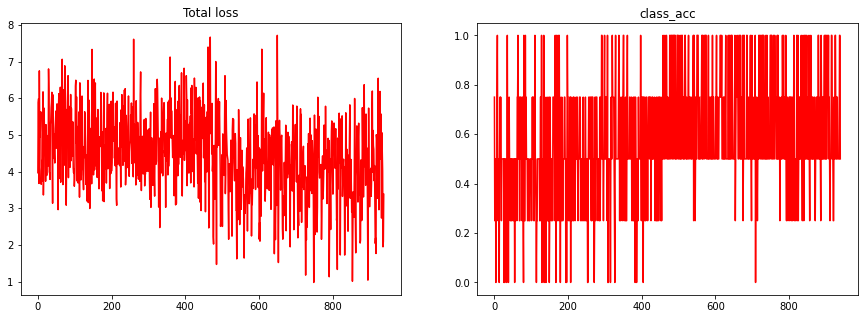

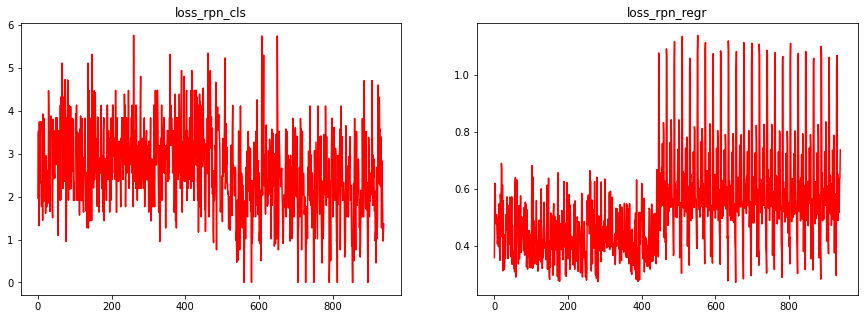

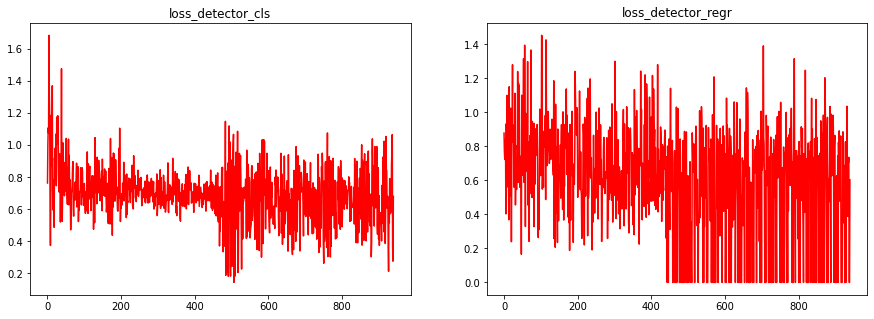

In [41]:
plot_loss(history[60:])

In [ ]:
#TODO: Provare YOLO -> forse meglio le efficientNet
# Ablation study
# Provare, a parità di frequenza, le esposizioni diverse come canali

In [1]:
# from tensorflow.keras.applications import EfficientNetB0
# model = EfficientNetB0(weights='imagenet')